<h1 align=center><font size = 5>Segmenting, Clustering and Comparing Neighborhoods from  New York City and London</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import json # librart to handle json files

# Matplotlib and associated plotting modules

# from matplotlib import rcParams
# rcParams['figure.figsize'] = 11, 8

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

# import to encode categorized features
from sklearn import preprocessing

import folium # map rendering library

from unidecode import unidecode

from lxml import html

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

#### Load and explore the data

In [3]:
try:
    nyc_data = requests.get("https://cocl.us/new_york_dataset").json()
except Exception:
    with open('newyork_data.json', 'r') as json_data:
        nyc_data = json.load(json_data)
print('Data downloaded!')

Data downloaded!


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = nyc_data['features']

Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['borough', 'neighborhood', 'latitude', 'longitude'] 

# instantiate the dataframe
nyc_data = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
nyc_data

,borough,neighborhood,latitude,longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_data = nyc_data.append({'borough': borough,
                                'neighborhood': neighborhood_name,
                                'latitude': neighborhood_lat,
                                'longitude': neighborhood_lon
                                },
                               ignore_index=True
                               )

Quickly examine the resulting dataframe.

In [9]:
nyc_data.head()

,borough,neighborhood,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_data['borough'].unique()),
        nyc_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Let's encode NYC's boroughs

In [11]:
region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(nyc_data['borough'])
nyc_data.insert(1, 'borough_encoded', region_encoder.transform(nyc_data['borough']))
nyc_data.head()

,borough,borough_encoded,neighborhood,latitude,longitude
0,Bronx,0,Wakefield,40.894705,-73.847201
1,Bronx,0,Co-op City,40.874294,-73.829939
2,Bronx,0,Eastchester,40.887556,-73.827806
3,Bronx,0,Fieldston,40.895437,-73.905643
4,Bronx,0,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

num_borough = nyc_data['borough_encoded'].unique()
color_range = list(range(0, len(num_borough)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, borough_encoded in zip(nyc_data['latitude'], nyc_data['longitude'], nyc_data['borough'], nyc_data['neighborhood'], nyc_data['borough_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[borough_encoded],
        fill=True,
        fill_color=cat_colors[borough_encoded],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)
    
map_nyc

## 2. Explore Neighborhoods in Manhattan

#### Define Foursquare Credentials and Version

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

CLIENT_ID = os.getenv('CLIENT_ID') # your Foursquare ID
CLIENT_SECRET = os.getenv('CLIENT_SECRET') # your Foursquare Secret
VERSION = os.getenv('VERSION') # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:


TypeError: can only concatenate str (not "NoneType") to str

#### Let's create a function to repeat the same process to all the neighborhoods

In [15]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *nyc_venues*.

In [16]:
# type your answer here
nyc_venues = getNearbyVenues(names=nyc_data['neighborhood'],
                             latitudes=nyc_data['latitude'],
                             longitudes=nyc_data['longitude']
                             )
nyc_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Let's check the size of the resulting dataframe

In [17]:
print(nyc_venues.shape)
nyc_venues.head()

(10144, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [18]:
nyc_venues.groupby('neighborhood').count().head()

,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
neighborhood,,,,,,
Allerton,31,31,31,31,31,31
Annadale,11,11,11,11,11,11
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,22,22,22,22,22,22


#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(nyc_venues['venue_category'].unique())))

There are 430 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [23]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['neighborhood'] = nyc_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head()

(10144, 431)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
nyc_grouped = nyc_onehot.groupby('neighborhood').mean().reset_index()
print(nyc_grouped.shape)
nyc_grouped.head()

(302, 431)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = nyc_grouped['neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Discount Store,Supermarket,Spa,Chinese Restaurant,Gas Station,Playground,Bakery,Pharmacy
1,Annadale,Pizza Place,American Restaurant,Food,Train Station,Restaurant,Dance Studio,Park,Deli / Bodega,Diner,Farm
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,Bus Stop,Home Service,Boat or Ferry,Grocery Store,Flea Market,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Beach,Hotel,Middle Eastern Restaurant,Outdoors & Recreation,Pharmacy,Liquor Store,Bagel Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

Before running the *k*-means model, let's use the elbow model to selected the best K.

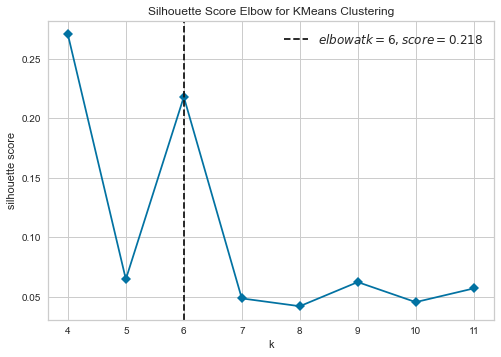

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [27]:
from yellowbrick.cluster import KElbowVisualizer

nyc_part_clustering = nyc_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=False)

visualizer.fit(nyc_part_clustering)  # Fit the data to the visualizer
visualizer.poof()

Run *k*-means to cluster the neighborhood into 5 clusters.

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Use silhouette score
range_n_clusters = list(range(4,13))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(nyc_part_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score(nyc_part_clustering, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 4, silhouette score is 0.04809933579407042)
For n_clusters = 5, silhouette score is 0.04455173434813656)
For n_clusters = 6, silhouette score is 0.20093214412674454)
For n_clusters = 7, silhouette score is 0.2359284843254664)
For n_clusters = 8, silhouette score is 0.043974616460143306)
For n_clusters = 9, silhouette score is 0.1865964376138375)
For n_clusters = 10, silhouette score is 0.044668072422795795)
For n_clusters = 11, silhouette score is 0.043654398723677296)
For n_clusters = 12, silhouette score is 0.04081265429207079)


In [29]:
# set number of clusters
kclusters = 10
nyc_grouped_clustering = nyc_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 3, 3, 3, 7, 7, 7, 7, 7], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

nyc_merged = nyc_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

print(nyc_merged.head())
nyc_merged.head() # check the last columns!

borough  borough_encoded neighborhood   latitude  longitude  cluster_labels  \
0   Bronx                0    Wakefield  40.894705 -73.847201               2   
1   Bronx                0   Co-op City  40.874294 -73.829939               2   
2   Bronx                0  Eastchester  40.887556 -73.827806               2   
3   Bronx                0    Fieldston  40.895437 -73.905643               7   
4   Bronx                0    Riverdale  40.890834 -73.912585               7   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy           Gas Station           Pizza Place   
1           Bus Station     Accessories Store           Pizza Place   
2           Bus Station  Caribbean Restaurant         Deli / Bodega   
3                 River                 Plaza  Medical Supply Store   
4                  Park            Playground                   Gym   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Sandwich

,borough,borough_encoded,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,0,Wakefield,40.894705,-73.847201,2,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
1,Bronx,0,Co-op City,40.874294,-73.829939,2,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Bronx,0,Eastchester,40.887556,-73.827806,2,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
3,Bronx,0,Fieldston,40.895437,-73.905643,7,River,Plaza,Medical Supply Store,Yoga Studio,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,0,Riverdale,40.890834,-73.912585,7,Park,Playground,Gym,Bus Station,Plaza,Bank,Food Truck,Home Service,Moving Target,Field


Finally, let's visualize the resulting clusters

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['latitude'], nyc_merged['longitude'], nyc_merged['neighborhood'], nyc_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [32]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 0, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
207,4,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 2

In [33]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 1, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,3,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
179,3,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
204,4,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
302,3,Dog Run,Food Truck,Shoe Store,Gym / Fitness Center,Diner,Bus Stop


#### Cluster 3

In [34]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 2, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
1,0,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,0,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
5,0,Bakery,Mexican Restaurant,Supermarket,Liquor Store,Spanish Restaurant,Fried Chicken Joint
6,2,Yoga Studio,Seafood Restaurant,Pharmacy,Pizza Place,Supplement Shop,Video Game Store
8,0,Deli / Bodega,Pharmacy,Athletics & Sports,Coffee Shop,Mexican Restaurant,Grocery Store
10,0,Pet Store,Bank,Men's Store,Pizza Place,Fried Chicken Joint,Fast Food Restaurant
11,0,Sushi Restaurant,Performing Arts Venue,Chinese Restaurant,Coffee Shop,Smoke Shop,Bank
13,0,Pharmacy,Deli / Bodega,Spanish Restaurant,Supermarket,Sandwich Place,Baseball Field
14,0,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Pharmacy,Bank


#### Cluster 4

In [35]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 3, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,0,Hookah Bar,BBQ Joint,Bakery,Donut Shop,Chinese Restaurant,Spanish Restaurant
45,0,Playground,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market
89,1,Grocery Store,Dry Cleaner,Fried Chicken Joint,Food,Chinese Restaurant,Mexican Restaurant
144,3,Arts & Crafts Store,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
150,3,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
156,3,Motel,Pizza Place,Mobile Phone Shop,Donut Shop,Seafood Restaurant,Flower Shop
159,3,Indian Restaurant,Home Service,Gym,Playground,Financial or Legal Service,Factory
171,3,Pizza Place,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
193,3,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
195,3,Gym / Fitness Center,Museum,Mobile Phone Shop,Mexican Restaurant,Coffee Shop,Gym


#### Cluster 5

In [36]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 4, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
192,3,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
203,4,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 6

In [37]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 5, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,0,Dessert Shop,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
41,0,Metro Station,Bakery,Convenience Store,Food,Pizza Place,Falafel Restaurant
56,1,Park,Supermarket,Chinese Restaurant,Print Shop,Liquor Store,Pharmacy
74,1,Caribbean Restaurant,Gym,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
75,1,Bus Station,Discount Store,Park,Paper / Office Supplies Store,Lounge,Nightclub
165,3,Café,Southern / Soul Food Restaurant,Motorcycle Shop,Grocery Store,Fast Food Restaurant,Chinese Restaurant
168,3,Cosmetics Shop,Chinese Restaurant,Restaurant,Pharmacy,Nightclub,Fast Food Restaurant
188,3,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
259,1,Donut Shop,Pharmacy,Café,Sandwich Place,Fish Market,Gas Station
300,1,Supermarket,Music Venue,Fried Chicken Joint,Bus Line,Food Truck,Yoga Studio


#### Cluster 7

In [38]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 6, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
183,3,Fried Chicken Joint,French Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market


#### Cluster 8

In [39]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 7, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,0,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,0,Plaza,Bank,Food Truck,Home Service,Moving Target,Field
7,0,Playground,Plaza,Food Truck,Food & Drink Shop,Grocery Store,Park
12,0,Jewelry Store,Diner,Baseball Field,Spanish Restaurant,Café,Smoke Shop
22,0,Peruvian Restaurant,Donut Shop,Latin American Restaurant,Storage Facility,Restaurant,Food
27,0,Bus Stop,Grocery Store,Scenic Lookout,Pool,Financial or Legal Service,Yoga Studio
28,0,Deli / Bodega,Sports Bar,American Restaurant,Asian Restaurant,Pizza Place,Mobile Phone Shop
29,0,Yoga Studio,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,Farm
34,0,Bank,Donut Shop,Dessert Shop,Spanish Restaurant,Coffee Shop,Bar
35,0,Tennis Court,Scenic Lookout,Tennis Stadium,Grocery Store,Thai Restaurant,Intersection


#### Cluster 9

In [40]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 8, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
257,4,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 10

In [41]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 9, nyc_merged.columns[[1] + list(range(10, nyc_merged.shape[1]))]]

,borough_encoded,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,1,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
238,4,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


# London

London is composed of 32 boroughs plus the City of London that are grouped in 5 sub-regions. Each borough is composed of a few "areas" which are equivalent to the neighborhoods in New York City. So in order to create a similar dataset I will collect data from two wikipedia pages and combine the results.

In [42]:
url_areas = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
url_regions = 'https://en.wikipedia.org/wiki/List_of_sub-regions_used_in_the_London_Plan'

session = requests.session()
session.verify = False

resp_areas = session.get(url_areas)
resp_regions = session.get(url_regions)

root_areas = html.fromstring(resp_areas.content)
root_regions = html.fromstring(resp_regions.content)

In [43]:
# Function to extract data from wikipedia tables
def extract_data(root):
    row_combox = root.xpath('.//table[contains(@class, "wikitable")]')
    row_combox = row_combox[0].xpath('.//tbody/tr')
    cols = [unidecode(line.text.strip()).replace(" ", "_").lower() if line.text is not None else None for line in list(row_combox[0])]

    data = []
    for row in row_combox[1:]:
        row_dict = {}
        for col in zip(cols, list(row)):
            row_dict[col[0]] = col[1].text_content().split('[')[0].strip()
        
        data.append(row_dict)
    
    return data

In [44]:
london_areas = extract_data(root_areas)
london_areas = pd.DataFrame(london_areas)
print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### Data Wrangling 

First, I will modify the london_areas data so there is only one borough per location. The reason for that, is because in order to assign a region to a location, I need to know its borough. Let's use the geopy library to search the location and use the borough it returns. 

Remove parentheses from location  

In [47]:
def remove_parentheses(row):
    location = row['location']
    if '(' in location:
        location = location.split('(')[0].strip()
    return location

In [48]:
london_areas['location'] = london_areas.apply(remove_parentheses, axis=1)
print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Select locations with more than one borough

In [49]:
borough_comma = london_areas.loc[london_areas['london_borough'].str.contains(', | &')]
print(borough_comma.shape)
borough_comma.head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,"Redbridge, Barking and Dagenham",ROMFORD,RM6,020,TQ485885
99,Chiswick,"Hounslow, Ealing, Hammersmith and Fulham",LONDON,W4,020,TQ205785
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755


In [50]:
def select_neighborhood(row):
    area = row['location']
    borough = row['london_borough']
    nomi = Nominatim(user_agent='london_app')
    result = nomi.geocode(f'{area}, London, United Kingdom')
    
    for line in result[0].split(','):
        if 'Borough of' in line:
            borough = line.split('of')[-1].strip()
            break
        
    return borough

In [51]:
borough_comma.loc[:, 'london_borough'] = borough_comma.apply(select_neighborhood, axis=1)
borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755
121,Cricklewood,"Barnet, Brent, Camden",LONDON,NW2,020,TQ235855
392,Ruxley,"Bexley, Bromley","SIDCUP, ORPINGTON","DA14, BR5","020, 01689",TQ485704
457,Temple,"City, Westminster",LONDON,"EC4, WC2",020,TQ311809
459,Thamesmead,"Bexley, Greenwich","LONDON, ERITH","SE28, SE2, DA18",020,TQ475805
479,Upper Ruxley,"Bexley, Bromley","SIDCUP, ORPINGTON","DA14, BR5","020, 01689",TQ4970


As we can see there are still some locations where it wasn't possible to update the neighborhood using geopy so those I will research online and fix by hand.  

In [181]:
indexes = borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')].index
new_boroughs = ['Lambeth', 'Camden', 'Bromley', 'City', 'Greenwich', 'Bromley']

borough_comma.loc[indexes, 'london_borough'] = new_boroughs
print(borough_comma)
borough_comma

ValueError: cannot copy sequence with size 6 to array axis with dimension 27

In [182]:
london_areas.loc[borough_comma.index, 'london_borough'] = borough_comma['london_borough']
print(london_areas.iloc[borough_comma.index].shape)
london_areas.iloc[borough_comma.index].head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,"Redbridge, Barking and Dagenham",ROMFORD,RM6,020,TQ485885
99,Chiswick,"Hounslow, Ealing, Hammersmith and Fulham",LONDON,W4,020,TQ205785
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755


Convert OS Grid (British National Grid References) to Latitude & Longitude

In [183]:
from OSGridConverter import grid2latlong

def grid_conversion(row):
    grid = row['os_grid_ref'].strip()
    latitude = None
    longitude = None
    if len(grid):
        coord = grid2latlong(grid)
        latitude = coord.latitude
        longitude = coord.longitude
    
    else:
        nomi = Nominatim(user_agent='london_app')
        location = row['location']
        borough = row['london_borough']
        result = nomi.geocode(f'{location}, {borough}, London, United Kingdom')

        if result is not None:
            latitude = result[1][0]
            longitude = result[1][1]

    return latitude, longitude

In [184]:
london_areas[['latitude', 'longitude']] = ''

london_areas[['latitude', 'longitude']] = london_areas.apply(grid_conversion, axis=1, result_type='expand')
print(london_areas.shape)
london_areas.head()

(533, 8)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663


Rename borough "City" to "City of London"

In [185]:
london_areas['london_borough'] = london_areas['london_borough'].str.replace('City', 'City of London')
london_areas.head(10)

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663
5,Aldborough Hatch,Redbridge,ILFORD,IG2,020,TQ455895,51.585581,0.099459
6,Aldgate,City of London,LONDON,EC3,020,TQ334813,51.514885,-0.078356
7,Aldwych,Westminster,LONDON,WC2,020,TQ307810,51.512819,-0.117388
8,Alperton,Brent,WEMBLEY,HA0,020,TQ185835,51.537976,-0.292401
9,Anerley,Bromley,LONDON,SE20,020,TQ345695,51.408585,-0.066989


Fix problematic locations

In [186]:
london_areas.loc[(london_areas['location'] == 'Brompton') | (london_areas['location'] == 'Sudbury') | (london_areas['location'] == 'Somerstown')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and ChelseaHammersmith and Fulham,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somerstown,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,"Brent, Ealing, Harrow","HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


In [187]:
london_areas.loc[68, 'london_borough'] = 'Kensington and Chelsea'
london_areas.loc[411, 'location'] = 'Somers Town'
london_areas.loc[448, 'london_borough'] = 'Brent'
london_areas.iloc[[68, 411, 448]]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and Chelsea,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somers Town,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Brent,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


Now that we fixed the dataset, let's check if we got 33 unique boroughs, which is London's official number of boroughs.

In [188]:
len(london_areas['london_borough'].unique())

59

We have 3 more boroughs than we should have. In order to find out which ones are wrong, I will download an oficial government dataset containing information about London's boroughs and will compare it with our list.

In [189]:
official_boroughs = pd.read_csv('https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv', engine='python', encoding='latin1')
official_boroughs.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,15.5,-7,665,30,.,United States,2.8,France,2,Australia,1.9,27.5,17.1,975,152.2,India,France,United States,64.6,.,.,.,1.6,.,3.4,.,.,.,.,.,.,"£63,620",.,500400,3.4,84.3,26130,64.3,.,12.3,.,799999,931.2,80,.,.,.,.,4.8,1036,34.4,1692,0.4,16.9,7.9,78.6,101,.,7.9,.,.,.,6.6,7.1,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,

In [190]:
official_boroughs.dropna(inplace=True)
official_areas = official_boroughs['Area_name']
official_areas.head()

1    Barking and Dagenham
2                  Barnet
3                  Bexley
4                   Brent
5                 Bromley
Name: Area_name, dtype: object

In [191]:
# Extra boroughs
myareas = pd.Series(london_areas['london_borough'].unique())

myareas.loc[~myareas.isin(official_areas)]

0                           Bexley,  Greenwich
1               Ealing, Hammersmith and Fulham
5                               City of London
31             Redbridge, Barking and Dagenham
32    Hounslow, Ealing, Hammersmith and Fulham
33                         Lambeth, Wandsworth
34                             Barnet, Enfield
37                       Barnet, Brent, Camden
39                                    Dartford
40                           Bexley, Greenwich
41                  Islington & City of London
42                         Haringey, Islington
44                         Greenwich, Lewisham
45                          Lambeth, Southwark
46                               Brent, Harrow
47                               Brent, Camden
48                        Camden and Islington
49                         Haringey and Barnet
50                               Brent, Ealing
51                               Harrow, Brent
52                             Bexley, Bromley
53           

Fix problematic boroughs

In [192]:
london_areas.loc[(london_areas['london_borough'] == 'Dartford')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
133,Dartford,Dartford,LONDON,DA5,020,TQ287861,51.55911,-0.144352


In [193]:
london_areas.loc[133, 'london_borough'] = 'Bexley'
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Camden and Islington', 'Camden')
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Haringey and Barnet', 'Haringey')


len(london_areas['london_borough'].unique())

56

In [194]:
# Rename columns
london_areas.rename(columns={'location': 'neighborhood', 'london_borough': 'borough'}, inplace=True)

Now let's collect the assign the locations to its respective regions 

In [195]:
london_regions = extract_data(root_regions)
london_regions = pd.DataFrame(london_regions)
print(london_regions.shape)
london_regions.head()

(5, 3)


,sub-region,london_boroughs,area
0,Central,"Camden, City of London, Kensington and Chelsea...","13,136.02 hectares (50.7185 sq mi)"
1,East,"Barking and Dagenham, Bexley, Greenwich, Hackn...","47,673.77 hectares (184.0695 sq mi)"
2,North,"Barnet, Enfield, Haringey","19,853.67 hectares (76.6554 sq mi)"
3,South,"Bromley, Croydon, Kingston upon Thames, Merton...","44,936.52 hectares (173.5009 sq mi)"
4,West,"Brent, Ealing, Hammersmith and Fulham, Harrow,...","33,868.62 hectares (130.7675 sq mi)"


Spread the dataset

In [196]:
london_regions = pd.DataFrame(london_regions['london_boroughs'].str.split(',').tolist(), index=london_regions['sub-region']).stack()
london_regions = london_regions.reset_index()[['sub-region', 0]]

london_regions = london_regions.apply(lambda x: x.str.strip())

london_regions.rename(columns={'sub-region': 'sub_region', 0: 'borough'}, inplace=True)
london_regions.head()

,sub_region,borough
0,Central,Camden
1,Central,City of London
2,Central,Kensington and Chelsea
3,Central,Islington
4,Central,Lambeth


Now, let's merge the tables

In [197]:
london_data = pd.merge(london_regions, london_areas[['borough', 'neighborhood', 'latitude', 'longitude']], on='borough', how='inner').reset_index(drop=True)
london_data.head()

,sub_region,borough,neighborhood,latitude,longitude
0,Central,Camden,Belsize Park,51.545049,-0.165131
1,Central,Camden,Bloomsbury,51.526345,-0.119715
2,Central,Camden,Camden Town,51.544548,-0.133398
3,Central,Camden,Chalk Farm,51.543969,-0.153628
4,Central,Camden,Fitzrovia,51.518533,-0.137347


In [198]:
# Check for nulls 
london_data.isnull().sum()

sub_region      0
borough         0
neighborhood    0
latitude        0
longitude       0
dtype: int64

In [199]:
num_neighborhoods = london_data.shape[0]
num_boroughs = len(london_data['borough'].unique())
print(f'There are {num_boroughs} boroughs and {num_neighborhoods} neighborhoods in London.')

There are 33 boroughs and 507 neighborhoods in London.


Now that the dataset is clean, let's check for duplicates in the coordinates. The reason this wasn't done before is because I wanted to fix the inconsistencies beforehand so I have the correct data to search for the correct coordinates in case I have to fix something.

In [200]:
duplicated_coord = london_data.loc[london_data.duplicated(subset=['latitude', 'longitude'], keep=False)]
print(duplicated_coord.shape)
duplicated_coord.head()

(95, 5)


,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.526345,-0.119715
8,Central,Camden,Highgate,51.571737,-0.146726
9,Central,Camden,Holborn,51.517359,-0.120085
11,Central,Camden,King's Cross,51.535100,-0.104923
14,Central,Camden,St Giles,51.517359,-0.120085


In [201]:
print(f"There are {duplicated_coord.shape[0]} neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them")

There are 95 neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them


In [202]:
nomi = Nominatim(user_agent='london')
nomi.geocode(f'Bloomsbury, Camden, London, United Kingdom')[1]

(51.523126, -0.1260664)

In [203]:
# Get coordinates 
def get_coordinates(row):
    neighborhood = row['neighborhood'] 
    borough = row['borough']
    nomi = Nominatim(user_agent='london')
    result = nomi.geocode(f'{neighborhood}, {borough}, London, United Kingdom')
    
    latitude = None
    longitude = None
    
    if result is not None:
        latitude = result[1][0]
        longitude = result[1][1]
        
    return latitude, longitude

In [204]:
duplicated_coord[['latitude', 'longitude']] = duplicated_coord.apply(get_coordinates, axis=1, result_type='expand')
duplicated_coord

,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.523126,-0.126066
8,Central,Camden,Highgate,51.574432,-0.152684
9,Central,Camden,Holborn,51.517934,-0.119528
11,Central,Camden,King's Cross,51.532395,-0.123022
14,Central,Camden,St Giles,51.515472,-0.128418
15,Central,Camden,St Pancras,51.532291,-0.125999
21,Central,Kensington and Chelsea,Brompton,51.491822,-0.178326
25,Central,Kensington and Chelsea,Kensington,51.498995,-0.199123
26,Central,Kensington and Chelsea,North Kensington,51.519665,-0.210696
30,Central,Islington,Angel,51.531842,-0.105714


Look for, and fix nulls values in the new coordinates

In [205]:
duplicated_coord.loc[duplicated_coord.isnull().any(1)]

,sub_region,borough,neighborhood,latitude,longitude
98,East,Bexley,"Bexley (also Old Bexley, Bexley Village)",NaN,NaN
99,East,Bexley,Bexleyheath (also Bexley New Town),NaN,NaN
114,East,Bexley,North End,NaN,NaN
239,East,Waltham Forest,Cann Hall,NaN,NaN
249,North,Barnet,"Barnet (also Chipping Barnet, High Barnet)",NaN,NaN


After checking on Google, the original coordinates for those two neighborhoods were correct so I will keep them in the dataset and update the new ones.

In [206]:
index2update = np.setdiff1d(duplicated_coord.index, duplicated_coord.loc[duplicated_coord.isnull().any(1)].index)
london_data.loc[index2update, ['latitude', 'longitude']] = duplicated_coord.loc[index2update, ['latitude', 'longitude']]

print(f"There are {london_data.duplicated(subset=['latitude', 'longitude'], keep=False).sum()} duplicate coordinates left.")

There are 0 duplicate coordinates left.


#### Change the coordinates columns data type

In [207]:
london_data['latitude'] = london_data['latitude'].astype('float64')
london_data['longitude'] = london_data['longitude'].astype('float64')
london_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sub_region    507 non-null    object 
 1   borough       507 non-null    object 
 2   neighborhood  507 non-null    object 
 3   latitude      507 non-null    float64
 4   longitude     507 non-null    float64
dtypes: float64(2), object(3)
memory usage: 19.9+ KB


Use geopy library to get the latitude and longitude values of London.

In [208]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London are {}, {}.'.format(latitude, longitude))

The geographical coordinate of London are 51.5073219, -0.1276474.


Encode "sub_region" column

In [209]:
from sklearn import preprocessing

region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(london_data['sub_region'])
region_encoder.classes_

array(['Central', 'East', 'North', 'South', 'West'], dtype=object)

In [210]:
london_data.insert(1, 'sub_region_encoded', region_encoder.transform(london_data['sub_region']))
london_data.head()

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude
0,Central,0,Camden,Belsize Park,51.545049,-0.165131
1,Central,0,Camden,Bloomsbury,51.523126,-0.126066
2,Central,0,Camden,Camden Town,51.544548,-0.133398
3,Central,0,Camden,Chalk Farm,51.543969,-0.153628
4,Central,0,Camden,Fitzrovia,51.518533,-0.137347


#### Create a map of London with neighborhoods superimposed on top.

In [211]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the sub regions
num_regions = london_data['sub_region_encoded'].unique()
color_range = list(range(0, len(num_regions)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, region in zip(london_data['latitude'], london_data['longitude'], london_data['borough'], london_data['neighborhood'], london_data['sub_region_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[region],
        fill=True,
        fill_color=cat_colors[region],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## 2. Explore Neighborhoods in London

In [212]:
london_venues = getNearbyVenues(names=london_data['neighborhood'],
                                latitudes=london_data['latitude'],
                                longitudes=london_data['longitude']
                                )

Belsize Park
Bloomsbury
Camden Town
Chalk Farm
Fitzrovia
Frognal
Gospel Oak
Hampstead
Highgate
Holborn
Kentish Town
King's Cross
Primrose Hill
Somers Town
St Giles
St Pancras
Swiss Cottage
West Hampstead
Aldgate
Barbican
Blackfriars
Brompton
Chelsea
Earls Court
Holland Park
Kensington
North Kensington
Notting Hill
South Kensington
West Brompton
Angel
Archway
Barnsbury
Canonbury
Clerkenwell
De Beauvoir Town
Finsbury
Highbury
Holloway
Islington
Nag's Head
Pentonville
St Luke's
Upper Holloway
Brixton
Gipsy Hill
Herne Hill
Lambeth
Oval
Stockwell
Streatham
Tulse Hill
Vauxhall
West Norwood
Bankside
Bermondsey
Camberwell
Denmark Hill
Dulwich
East Dulwich
Elephant and Castle
Newington
Nunhead
Peckham
Rotherhithe
Surrey Quays
Walworth
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Knightsbridge
Lisson Grove
Little Venice
Maida Vale
Marylebone (also St Marylebone)
Mayfair
Millbank
Paddington
Pimlico
Soho
St James's
St John's Wood
Westminster
Barking
Becontree
Becontree Heath
C

#### Let's check the size of the resulting dataframe

In [213]:
print(london_venues.shape)
london_venues.head()
london_venues.shape

(10838, 7)


(10838, 7)

Let's check how many venues were returned for each neighborhood

In [214]:
london_venues.groupby('neighborhood').count()
london_venues.groupby('neighborhood').count().shape

(495, 6)

#### Let's find out how many unique categories can be curated from all the returned venues

In [215]:
print('There are {} uniques categories.'.format(len(london_venues['venue_category'].unique())))

There are 418 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [216]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['neighborhood'] = london_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print(london_onehot.shape)
london_onehot.head()

(10838, 419)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Gym,College Quad,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [217]:
london_grouped = london_onehot.groupby('neighborhood').mean().reset_index()
print(london_grouped.shape)
london_grouped.head()

(495, 419)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Gym,College Quad,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop

#### Let's print each neighborhood along with the top 5 most common venues

In [218]:
num_top_venues = 10

for hood in london_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

4
7          Bakery  0.04
8  Sandwich Place  0.04
9     Pizza Place  0.04


----Upminster Bridge----
                   venue  freq
0          Metro Station  0.14
1                    Pub  0.14
2                   Park  0.14
3      Indian Restaurant  0.14
4                   Café  0.14
5               Windmill  0.14
6         Soccer Stadium  0.14
7      Accessories Store  0.00
8      Paella Restaurant  0.00
9  Performing Arts Venue  0.00


----Upper Clapton----
                   venue  freq
0                   Café  0.33
1        Harbor / Marina  0.17
2                  River  0.17
3        Nature Preserve  0.17
4                   Park  0.17
5      Paella Restaurant  0.00
6     Persian Restaurant  0.00
7           Perfume Shop  0.00
8  Performing Arts Venue  0.00
9       Pedestrian Plaza  0.00


----Upper Holloway----
                  venue  freq
0         Grocery Store  0.17
1           Coffee Shop  0.14
2           Pizza Place  0.10
3    Italian Restaurant  0.07
4                 

#### Let's put that into a *pandas* dataframe and display the top 10 venues for each neighborhood

In [219]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = london_grouped['neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted.shape

(495, 11)

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [220]:
london_part_clustering = london_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,11), metric='silhouette', timings=False)

visualizer.fit(london_part_clustering)        # Fit the data to the visualizer
visualizer.poof()   

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [221]:
# set number of clusters
kclusters = 6

london_grouped_clustering = london_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 2, 2, 3, 3, 3, 2, 2, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Before the merge let's check if both tables have all the same neighborhoods

In [222]:
london_data.loc[~london_data['neighborhood'].isin(london_data['neighborhood'])]

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude


In [223]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

london_merged = london_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.iloc[:, 3:].join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood', how='inner')

london_merged.head() # check the last columns!
london_merged.shape

(501, 14)

In [224]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['neighborhood'], london_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [225]:
london_merged.loc[london_merged['cluster_labels'] == 0, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
247,51.644967,Fruit & Vegetable Store,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
292,51.649274,Fruit & Vegetable Store,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
447,51.565560,Fruit & Vegetable Store,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


#### Cluster 2

In [226]:
london_merged.loc[london_merged['cluster_labels'] == 1, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,51.574432,Gastropub,Bookstore,Café,Plaza,Pool,Bus Stop,Indian Restaurant,Farm
22,51.482096,Garden,Grocery Store,Pier,Steakhouse,Café,Monument / Landmark,Outdoor Sculpture,Farmers Market
29,51.486182,Pizza Place,Farmers Market,Italian Restaurant,Bistro,Gym,Gym / Fitness Center,Sandwich Place,Bakery
59,51.453517,Fish & Chips Shop,Grocery Store,Convenience Store,Post Office,Park,Zoo Exhibit,Exhibit,Fabric Shop
62,51.462265,Garden,Garden Center,Scenic Lookout,Zoo Exhibit,Fish & Chips Shop,Event Space,Exhibit,Fabric Shop
100,51.450799,Flea Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
104,51.458239,English Restaurant,Museum,Bar,Zoo Exhibit,Fish Market,Fabric Shop,Falafel Restaurant,Farm
107,51.473826,Park,Farm,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
109,51.418013,Supermarket,Zoo Exhibit,Fish Market,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm
111,51.481999,Zoo Exhibit,Flea Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 3

In [227]:
london_merged.loc[london_merged['cluster_labels'] == 2, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,51.564273,Pizza Place,Italian Restaurant,Asian Restaurant,Sandwich Place,Park,Farmers Market,Fast Food Restaurant,Café
51,51.445234,Grocery Store,Playground,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
88,51.563024,Turkish Restaurant,Gas Station,Pool,Golf Course,Supermarket,Gym / Fitness Center,Film Studio,Exhibit
93,51.566299,Grocery Store,Gas Station,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
94,51.434929,Indian Restaurant,Grocery Store,Fish Market,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm
95,51.458479,Grocery Store,Pet Store,Café,Golf Course,Fish & Chips Shop,Fabric Shop,Falafel Restaurant,Farm
101,51.448261,Pub,Supermarket,Lake,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant
108,51.476449,Coffee Shop,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
115,51.472855,Electronics Store,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
120,51.477239,Zoo Exhibit,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 4

In [228]:
london_merged.loc[london_merged['cluster_labels'] == 3, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,51.523126,Hotel,Pub,Bookstore,Italian Restaurant,Exhibit,History Museum,Pizza Place,Park
2,51.544548,Café,Garden Center,Italian Restaurant,Pizza Place,Event Space,Pet Store,Coffee Shop,Caribbean Restaurant
3,51.543969,Pub,Italian Restaurant,Coffee Shop,Pizza Place,Restaurant,Clothing Store,Bakery,French Restaurant
4,51.518533,Hotel,Clothing Store,French Restaurant,Italian Restaurant,Japanese Restaurant,Cocktail Bar,Café,Cycle Studio
5,51.552596,Pub,Italian Restaurant,Restaurant,Thai Restaurant,Tennis Court,Bookstore,Breakfast Spot,Spanish Restaurant
6,51.553764,French Restaurant,Grocery Store,Thai Restaurant,Beer Store,Gastropub,Music Venue,Café,Train Station
7,51.554215,Pub,Italian Restaurant,Ice Cream Shop,Thai Restaurant,Bagel Shop,English Restaurant,Coffee Shop,Gym / Fitness Center
9,51.517934,Bookstore,Hotel,Café,Coffee Shop,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Theater
10,51.544777,Market,Coffee Shop,Flea Market,Ice Cream Shop,Pizza Place,French Restaurant,Grocery Store,Beer Store
11,51.532395,Pizza Place,Burger Joint,Café,Train Station,Supermarket,Breakfast Spot,Modern European Restaurant,Tapas Restaurant


#### Cluster 5

In [229]:
london_merged.loc[london_merged['cluster_labels'] == 4, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,51.545049,Italian Restaurant,Hotel Bar,Hotel,Hill,Breakfast Spot,Brazilian Restaurant,Soccer Field,Outdoors & Recreation
25,51.498995,Supermarket,Pub,Clothing Store,Burger Joint,Cupcake Shop,Hostel,Furniture / Home Store,Breakfast Spot
37,51.552081,Restaurant,Fish & Chips Shop,Fast Food Restaurant,Tapas Restaurant,Middle Eastern Restaurant,Tennis Court,Cheese Shop,Park
46,51.453988,Train Station,Deli / Bodega,Flower Shop,Food & Drink Shop,Bakery,Convenience Store,Pub,Stadium
48,51.483752,Bus Stop,Cricket Ground,Coffee Shop,Italian Restaurant,Korean Restaurant,Gay Bar,Fried Chicken Joint,Park
53,51.427028,Park,Café,Sporting Goods Shop,Fish Market,Fabric Shop,French Restaurant,Falafel Restaurant,Farm
57,51.467421,Coffee Shop,Vietnamese Restaurant,Optical Shop,Grocery Store,Train Station,Park,Chinese Restaurant,Bar
75,51.521031,Italian Restaurant,Canal,Beer Bar,Theater,Sushi Restaurant,Garden Center,Garden,Food Truck
114,51.466929,Construction & Landscaping,Café,Platform,Flea Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm
117,51.467673,Construction & Landscaping,Café,Platform,Flea Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm


#### Cluster 6

In [230]:
london_merged.loc[london_merged['cluster_labels'] == 5, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
105,51.499571,Park,Zoo Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
125,51.469784,Zoo Exhibit,Frozen Yogurt Shop,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
133,51.482670,Historic Site,Fish & Chips Shop,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
137,51.556496,Bike Trail,Zoo Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
142,51.561113,Pub,Skating Rink,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Fabric Shop,Falafel Restaurant,Farm
153,51.611223,Park,Zoo Exhibit,Fish & Chips Shop,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
154,51.593254,Creperie,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
160,51.610141,Paper / Office Supplies Store,Restaurant,Zoo Exhibit,Fish & Chips Shop,Exhibit,Fabric Shop,Falafel Restaurant,Farm
163,51.619940,Zoo Exhibit,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
165,51.619125,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


## Comparison

In [231]:
nyc_venues.head()

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### 10 Most common venues in NYC

In [232]:

# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

In [134]:
nyc_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='blue')
plt.title("10 Most Common Venues in NYC")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Number of Venues')

#### "10 Most Common Venues in London

In [ ]:
london_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='blue')
plt.title("Top 10 Most Common Venues Categories in NYC")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

In [135]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['venue_category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
# fig.savefig('most-common-ven-nyc.png', dpi=300)

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity